__<h3>Author: IDIKA, UDUMA UDUMA</h3>__

__<h3>Major: Data Management and Artificial Intelligence</h3>__

__<h3>Topic: Building a Neural Network from Scratch using JAX</h3>__

__<h3>Objective:</h3>__

**Development of a Two-Layer Classification Neural Network from Scratch using JAX.**

I achieved this via the following steps:

Step 1: Defining the Neural Network Architecture  
Step 2: Initializing Weights and Biases <br>
Step 3: Implementing the Forward Pass <br>
Step 4: Defining the Loss Function <br>
Step 5: Implementing the Backpropagation Algorithm <br>
Step 6: Updating Model Parameters (Weights and Biases) using Gradient Descent <br>
Step 7: Training Loop Implementation <br>
Step 8: Evaluating Model Performance <br>
Step 9: Evaluating Model Accuracy on Test Set <br>

In addition, I developed a **Fourier Basis function** as a function approximation model for features transformation 
before feeding the features through a neural network architecture.


In [5]:
#Importing the necessary libraries
import jax
import jax.numpy as jnp
from jax import grad
import jax.random as random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

**<h3>Part A: Development of a Fourier Basis Function for Features Transformation</h3>**

In [7]:
#Step 1: Understanding and Defining the  Dataset of UCI Human Activity Recognition (HAR) Using Smartphones

#Data Source: UCI Machine Learning Repository - https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones


#Features:
# - 561 features present
# - They are time-series signals from smartphone accelerometers and gyroscopes

#Target:
#The target has 6 classes
# Each class represents one of the six available classes present (walking, walking upstairs, walking downstairs, sitting, standing, laying).


# Load feature names
feature_names_df = pd.read_csv("features.txt", sep=r"\s+", header=None, names=["index", "feature_name"])

# Ensure unique feature names by appending an index to duplicates
feature_names_df["feature_name"] = feature_names_df["feature_name"].astype(str)
feature_names = pd.Series(feature_names_df["feature_name"]).rename_axis("idx").reset_index()

# Resolve duplicates by appending a count index
feature_names["unique_name"] = feature_names.groupby("feature_name")["idx"].rank(method="first", ascending=True).astype(int)
feature_names["feature_name"] = feature_names.apply(lambda x: f"{x['feature_name']}_{x['unique_name']}" if x["unique_name"] > 1 else x["feature_name"], axis=1)

# Convert to numpy array
feature_names = feature_names["feature_name"].values

# Load training features
X_train = jnp.array(pd.read_csv("train/X_train.txt", sep=r"\s+", header=None, names=feature_names))

# Load training labels
y_train = jnp.array(pd.read_csv("train/y_train.txt", header=None, names=["Activity"]).values).squeeze()

# Load test features
X_test = jnp.array(pd.read_csv("test/X_test.txt", sep=r"\s+", header=None, names=feature_names))

# Load test labels
y_test = jnp.array(pd.read_csv("test/y_test.txt", header=None, names=["Activity"]).values).squeeze()

#Step 2:
#Generating the Fourier Features

#First, we write a function that generates the Fourier Basis features for a given input, 'X' and M
M = 5

def fourier_basis(x, m):
    if x.ndim == 1:
        x_column = x.reshape(-1,1)            #Ensuring the input is a column vector
        k = jnp.arange(1, m+1).reshape(-1,1)  #Creating an array of frequencies
    
        ones_term = jnp.ones_like(x_column)              #Bias term. Shape: (n,1) where n is the number of elements. (50,1) in this case
        sine_terms = (jnp.sin(2 * jnp.pi * k.T * x_column))    #Broadcast between k.T => (1,m) and x_column => (n,1). Final Shape: (n,m) i.e. (50, 5) in this case
        cosine_terms = (jnp.cos(2 * jnp.pi * k.T * x_column))
        fourier_features = jnp.column_stack((ones_term, sine_terms, cosine_terms))
    
    if x.ndim == 2:
        n_samples, n_features = x.shape  # Number of samples and features
        k = jnp.arange(1, m + 1).reshape(-1, 1)  # Frequencies

        # Initialize the list to hold all Fourier terms
        fourier_terms = [jnp.ones((n_samples, 1))]  # Start with the bias term

        for feature in range(n_features):
            X = x[:, feature].reshape(-1, 1)  # Select the current feature
            # Sine and cosine terms for the current feature
            sine_terms = jnp.sin(2 * jnp.pi * k.T * X)  # Shape: (n_samples, m)
            cosine_terms = jnp.cos(2 * jnp.pi * k.T * X)  # Shape: (n_samples, m)

            # Append the sine and cosine terms to the list
            fourier_terms.append(sine_terms)
            fourier_terms.append(cosine_terms)

        # Concatenate all terms along the second axis
        fourier_features = jnp.hstack(fourier_terms)
  
    return fourier_features

x_fourier_train = fourier_basis(X_train, M)
x_fourier_test = fourier_basis(X_test, M)

#Printing the shapes of the train and test features
print(f"Shape of 'feature' train set: {x_fourier_train.shape}")
print(f"Shape of'feature' test set: {x_fourier_test.shape}\n")

print(f"Shape of 'target' train set: {y_train.shape}")
print(f"Shape of'target' test set: {y_test.shape}")


Shape of 'feature' train set: (7352, 5611)
Shape of'feature' test set: (2947, 5611)

Shape of 'target' train set: (7352,)
Shape of'target' test set: (2947,)


**<h3>Part B: Development of a Neural Network Model</h3>**

**Note: This Neural Network Implementation is for a 2-layer neural network**

In [10]:
#Step 1:
#Define an initialization function for the weights

def initialization_fn(key, shape):
        return random.normal(key, shape) * jnp.sqrt(2/shape[0])   #He initialization for ReLU activation

class NeuralNetwork:
    
    def __init__(self, key, input_dim, hidden_dim, output_dim):
        #Define the parameters of the network
        key1, key2 = random.split(key, num=2)
        
        self.W1 = initialization_fn(key1, (input_dim, hidden_dim))
        self.b1 = jnp.zeros(hidden_dim,)                                #biases are initialized to zero

        self.W2 = initialization_fn(key2, (hidden_dim, output_dim))
        self.b2 = jnp.zeros(output_dim,)


    def forward_pass(self, x):
        z1 = jnp.dot(x, self.W1) + self.b1     #pre-activation of the hidden layer
        h = jax.nn.relu(z1)                    #applying ReLU activation for the hidden layer

        z2 = jnp.dot(h, self.W2) + self.b2     #pre-activation of the output layer
        y_pred = jax.nn.softmax(z2)            #applying Softmax to get the probabilities of the predicted target

        return y_pred

x = x_fourier_train
y = y_train

#Creating an instance of the NeuralNetwork class
main_key = random.PRNGKey(42)
input_dim = x.shape[1]
hidden_dim = 400                              #Numboer of neurons in the hidden layer
output_dim = jnp.unique(y_train).size         #Number of neurons in the output layer corresponds to the number of distinct classes in the target

nn = NeuralNetwork(key=main_key, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)  #The _dim here refers to the number of neurons in each layer

#Wrapping the parameters in a "params" dictionary
params = {
    "W1": nn.W1,
    "b1": nn.b1,
    "W2": nn.W2,
    "b2": nn.b2
}


# Convert the target to One-Hot Encoding to obtain y_true
num_classes = jnp.unique(y_train).size
y_true = jnp.eye(num_classes)[y_train]

#Determine initial y_pred from the initial weights and bias initialization
y_pred = nn.forward_pass(x)

#Printing the shapes of the model's parameters
print("\nModel Architecture:")
for k,v in params.items():
    print(f"{k}: {v.shape}")


#Defining the loss function (cross-entropy)
def cross_entropy_loss(y_true, y_pred):
    return -jnp.mean(jnp.sum(y_true * jnp.log(y_pred + 1e-8), axis=1))   #Added 1e-8 to avoid log(0) that causes instability

#Defining the loss function wrapper to compute the gradient using the loss function
def loss_func(params, x, y_true):
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    
    z1 = jnp.dot(x, W1) + b1     #pre-activation of the hidden layer
    h = jax.nn.relu(z1)          #applying ReLU activation for the hidden layer

    z2 = jnp.dot(h, W2) + b2     #pre-activation of the output layer
    y_pred = jax.nn.softmax(z2)
    
    return cross_entropy_loss(y_true, y_pred)

#Automatically determining the gradients during backpropagation
grads = grad(loss_func)(params, x, y_true)

#Printing the initial values of the Model's parameters (params)
print("\nInitial Model Parameters:")
for k, v in params.items():
    print(f"{k}: {v}\n")


Model Architecture:
W1: (5611, 400)
b1: (400,)
W2: (400, 6)
b2: (6,)

Initial Model Parameters:
W1: [[ 0.00568704  0.03380947  0.02237879 ...  0.01826228 -0.03240708
   0.00025938]
 [ 0.04217771 -0.03270132  0.00511352 ... -0.01251905  0.0012203
   0.00826543]
 [ 0.01441404  0.02760401  0.03661674 ...  0.02681212  0.02742296
   0.01426434]
 ...
 [-0.00027428 -0.0239825   0.03206769 ... -0.01241341 -0.00484662
   0.0088717 ]
 [ 0.01042465  0.01452601  0.00502385 ...  0.00403174 -0.0031096
   0.00354301]
 [-0.00153755  0.01251395  0.05140643 ...  0.03141801 -0.00955447
  -0.03263802]]

b1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

**<h3>Model Parameters (Weights & Biases) Update using Gradient Descent  </h3>**

In [12]:
#Since JAX is designed for functional programming, 
#we will return updated parameters instead of modifying parameters in place

learning_rate=0.01

def update_params(params, gradients, learning_rate):
    """
    Performs a gradient descent update on the neural network parameters.
    
    Arguments:
    - params: Dictionary containing the initial model parameters (W1, b1, W2, b2).
    - gradients: Gradient function output from JAX, same structure as params.
    - learning_rate: Step size for parameter updates.
    
    Returns:
    - Updated parameters.
    """
    updated_params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, gradients)
    return updated_params

#Testing the function using our existing sample data

updated_params = update_params(params, grads, learning_rate)

#Printing the initial values of the Model's parameters (params)
print("Initial Model Parameters:")
for k, v in params.items():
    print(f"{k}: {v}\n")

#Printing the values of the model's updated_parameters
print("\nUpdated Model Parameters:")
for k, v in updated_params.items():
    print(f"{k}: {v}\n")

Initial Model Parameters:
W1: [[ 0.00568704  0.03380947  0.02237879 ...  0.01826228 -0.03240708
   0.00025938]
 [ 0.04217771 -0.03270132  0.00511352 ... -0.01251905  0.0012203
   0.00826543]
 [ 0.01441404  0.02760401  0.03661674 ...  0.02681212  0.02742296
   0.01426434]
 ...
 [-0.00027428 -0.0239825   0.03206769 ... -0.01241341 -0.00484662
   0.0088717 ]
 [ 0.01042465  0.01452601  0.00502385 ...  0.00403174 -0.0031096
   0.00354301]
 [-0.00153755  0.01251395  0.05140643 ...  0.03141801 -0.00955447
  -0.03263802]]

b1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

**<h3>Training Loop Implementation</h3>**

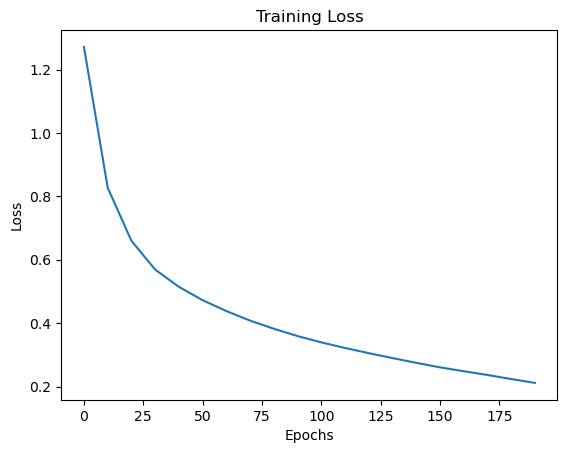

In [14]:
#This entails structuring our training process to iteratively update the parameters over multiple epochs
epochs = 200
def train_model(params, x_train, y_train, epochs, learning_rate):
    """
    Trains the neural network using gradient descent.

    Arguments:
    - params: Dictionary of initial model parameters.
    - x_train: Input training data.
    - y_train: True labels (one-hot encoded).
    - epochs: Number of iterations for training.
    - learning_rate: Step size for gradient descent.

    Returns:
    - params: Trained parameters after `epochs` iterations.
    - epoch_list: A list that contains some specified epochs
    - loss_list: A list that contains the loss for for the specified epochs
    """
    epoch_list = []
    loss_list = []
    
    for epoch in range(epochs):
        #Compute gradients
        grads = grad(loss_func)(params, x_train, y_train)

        #Update parameters
        params = update_params(params, grads, learning_rate)

        #Compute loss after 10 epochs for monitoring
        if epoch % 10 == 0:
            loss = loss_func(params, x_train, y_train)
            #print(f"Epoch {epoch}: Loss = {loss:.4f}")

            loss_value = float(loss)
            epoch_list.append(epoch)
            loss_list.append(round(loss_value, 4))

    return params, epoch_list, loss_list
        
#Testing the training loop
x_train = x.copy()
y_train = y_true.copy()

final_params, epoch_list, loss_list = train_model(params, x_train, y_train, epochs, learning_rate)

#Printing the final model parameters
#print(f"\nFinal Model Parameters:")
#for k, v in final_params.items():
    #print(f"{k}: {v}\n")

#Visualizing the loss over the epoch
import matplotlib.pyplot as plt

#print(loss_list)
#print(epoch_list)
plt.plot(epoch_list, loss_list)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show();

**<h3>Evaluating Model Performance </h3>**

In [16]:
#Compute the final loss of the model
final_loss = loss_func(final_params, x_train, y_train)
print(f"Final Loss: {final_loss:.4f}")

#Implementing a predict function to make predictions using the final_params
def predict(params, x):
    z1 = jnp.dot(x, params["W1"]) + params["b1"]
    h = jax.nn.relu(z1)

    z2 = jnp.dot(h, params["W2"]) + params["b2"]
    y_pred = jax.nn.softmax(z2)
    return y_pred

#Prediction on training data
y_pred = predict(final_params, x_train)
print(f"\nPredicted Values:\n{y_pred}")

#Evaluating Model Performance
def compute_accuracy(y_pred, y_true):
    """Compute accuracy by comparing predicted and actual labels"""
    predicted_labels = jnp.argmax(y_pred, axis=1)  #Getting the class with the highest probability
    actual_labels = jnp.argmax(y_true, axis=1)     #Getting the actual class labels
    accuracy = jnp.mean(predicted_labels == actual_labels)
    return accuracy

Final Loss: 0.1981

Predicted Values:
[[6.76441705e-04 4.77577996e-04 4.42522229e-04 8.93412915e-04
  1.11843266e-01 8.85666907e-01]
 [1.33459864e-04 2.91111151e-04 1.40650838e-04 2.52805767e-04
  3.88617694e-01 6.10564291e-01]
 [1.34364411e-04 3.31605377e-04 1.68751241e-04 5.15211490e-04
  1.33023977e-01 8.65826011e-01]
 ...
 [2.09298105e-05 1.71310399e-02 9.79761600e-01 2.12004920e-03
  4.32898087e-04 5.33493876e-04]
 [1.13297036e-04 1.68001540e-02 9.76582944e-01 5.23757283e-03
  1.65393416e-04 1.10063876e-03]
 [4.95315704e-04 1.72996391e-02 9.76372302e-01 2.84421397e-03
  1.90694438e-04 2.79785600e-03]]


In [17]:
#Computing the training accuracy
accuracy = compute_accuracy(y_pred, y_train)
print(f"\nTraining Accuracy: {accuracy * 100:.2f}%")


Training Accuracy: 95.14%


**<h3>Evaluating Model Accuracy on the Test Set</h3>**

In [19]:
#Prediction on test data
y_pred_test = predict(final_params, x_fourier_test)

y_true_test = jnp.eye(num_classes)[y_test]   #One-hot encoded values of the y_test

#Computing the test accuracy
accuracy_test = compute_accuracy(y_pred_test, y_true_test)
print(f"\nTesting Accuracy: {accuracy_test * 100:.2f}%")


Testing Accuracy: 86.94%
